In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

In [2]:
seq_len = 96
predict_len = 96
batch_size = 256
lr = 0.001
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#首先制作数据集
def get_data(csv,item,seq_len,predict_len):
    full_data = pd.read_csv(csv)
    data = full_data[item]
    
    data = np.array(data)
    
    x = []
    y = []
    
    for i in range(data.shape[0]-seq_len-predict_len):
        x_one = data[i:i+seq_len]
        y_one = data[i+seq_len:i+seq_len+predict_len]
        
        x_one = np.array(x_one)
        y_one = np.array(y_one)
        
        
        x.append(x_one)
        y.append(y_one)
        
    x = np.array(x)
    max_value = np.max(x)
    min_value = np.min(x)
    x = (x-min_value) / (max_value-min_value)
    y = np.array(y)
    
    
    train = int(x.shape[0]*0.8)
    valid = int(x.shape[0]*0.1)
    x_train,x_valid,x_test = x[:train],x[train:train+valid],x[train+valid:]
    y_train,y_valid,x_test = y[:train],y[train:train+valid],x[train+valid:]
    
    return x_train,x_valid,x_test,y_train,y_valid,x_test
        


In [4]:
x_train,x_valid,x_test,y_train,y_valid,y_test = get_data('./data/stations_data/df_station_1001.csv','PM25_Concentration',seq_len,predict_len)

In [5]:
class Mydataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        x = self.x[idx]
        if self.transform:
            x = self.transform(x)
        return x,self.y[idx]

In [6]:
train_dataset = Mydataset(x_train,y_train)
valid_dataset = Mydataset(x_valid,y_valid)
test_dataset = Mydataset(x_test,y_test)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [16]:
class SelfAttention(nn.Module):
    def __init__(self,embed_size,heads):
        super(SelfAttention,self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size),"Embed size needs to be divided by heads"

        self.values = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.keys = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.queries = nn.Linear(self.head_dim,self.head_dim,bias = False)
        self.fc_out = nn.Linear(heads * self.head_dim,embed_size)

    def forward(self,values,keys,query,mask=None):
        N = query.shape[0]
        value_len,key_len,query_len = values.shape[1],keys.shape[1],query.shape[1]

        #split embedding into self.heads pieces
        values = values.reshape(N,value_len,self.heads,self.head_dim)
        keys = keys.reshape(N,key_len,self.heads,self.head_dim)
        queries = query.reshape(N,key_len,self.heads,self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk",[queries,keys])
        #queries shape:(N,query_len,heads,head_dim)
        #keys shape:(N,key_len,heads,heads_dim)
        #energy shape:(N,heads,query_len,key_len)

        if mask is not None:
            energy = energy.masked_fill(mask == 0,float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)),dim = 3)

        out = torch.einsum("nhql,nlhd->nqhd",[attention,values]).reshape(
            N,query_len,self.heads*self.head_dim
        )

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self,embed_size,heads,dropout,forward_expansion):
        super(TransformerBlock,self).__init__()
        self.attention = SelfAttention(embed_size,heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size,forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size,embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query,mask=None):
        attention = self.attention(value,key,query,mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out
class Encoder(nn.Module):
    def __init__(self,src_size,embed_size,num_layers,heads,device,forward_expansion,
                 dropout,max_len):
        super(Encoder,self).__init__()
        self.embed_size = embed_size
        self.device = device
        #self.word_embedding = nn.Embedding(src_size,embed_size)
        self.position_embedding = nn.Embedding(max_len,embed_size)

        self.layers = nn.ModuleList([
            TransformerBlock(
                embed_size,
                heads,
                dropout=dropout,
                forward_expansion=forward_expansion
            ) for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)

    def forward(self,x,mask):
        N,seq_len = x.shape[0],x.shape[1]
        positions = torch.arange(0,seq_len).expand(N,seq_len).to(self.device)

        out = self.position_embedding(positions)
        for layer in self.layers:
            out = layer(out,out,out,mask)
        return out


class Transformer(nn.Module):
    def __init__(self,src_size,trg_size,seq_len,predict_len,
                 embed_size = 256,num_layers=6,forward_expansion=4,heads=8,
                 dropout=0,device="cuda",max_len=100):
        super(Transformer,self).__init__()
        self.encoder = Encoder(
            src_size,embed_size,num_layers,heads,device,forward_expansion,
            dropout,max_len
        )
        self.decoder = Decoder(
            trg_size,embed_size,num_layers,heads,forward_expansion,dropout,
            device, max_len
        )
        self.fc = nn.Sequential(
            nn.Linear(embed_size,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,4)
        )
        self.fc_out = nn.Linear(4*seq_len,predict_len)
        self.device = device

    def create_mask(self,N):
        #生成一个矩阵，对角线上的值为0
        mask = torch.ones((N,N))
        for i in range(N):
            mask[i,i] = 0
        mask = mask.to(device)
        return mask
    def forward(self,src):
        src_mask = self.create_mask(src.shape[1])
        enc_src = self.encoder(src,src_mask)
        x = self.fc(enc_src).reshape(src.shape[0],-1)
        out = self.fc_out(x)
        return out

In [17]:
model = Transformer(src_size=1,trg_size=1,seq_len=seq_len,predict_len=predict_len,
                 embed_size = 256,num_layers=6,forward_expansion=4,heads=8,
                 dropout=0,device=device,max_len=5000).to(device)

In [18]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [19]:
# 训练模型
# 训练模型
losses = []
val_losses = []
patience = 20  # 允许没有性能提升的epoch数量
# 初始化最佳损失和epoch计数器
best_loss = float('inf')
for epoch in range(num_epochs):
    for i,(seq,predict) in enumerate(train_loader):
        
        seq = seq.unsqueeze(dim=2).float().to(device)
        predict = predict.float().to(device)
    
        # 前向传播
        
        output = model(seq)
        
    
        # 计算损失
        
        loss = criterion(output, predict)
    
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if i % 20 == 0:
            print('epoch:{}/{},batch:{},loss:{:.4f}'.format(epoch,num_epochs,i,loss.item()))
            losses.append(loss.item())
            
    model.eval()   
    validation_losses = []
    with torch.no_grad():
        for i,(seq,predict) in enumerate(valid_loader):
        
            seq = seq.unsqueeze(dim=2).float().to(device)
            predict = predict.float().to(device)
            output = model(seq)
            loss = criterion(output, predict)
            validation_losses.append(loss.item())
        
        # 验证过程...
        validation_losses = np.array(validation_losses)
        validation_loss = np.mean(validation_losses)  # 计算验证集损失
        val_losses.append(validation_loss)
        
    
        # 检查是否是最佳模型
        if validation_loss < best_loss:
            best_loss = validation_loss
            print('best_loss:{:.4f}'.format(best_loss))
            epoch_no_improve = 0
            # 保存最佳模型的状态
            torch.save(model.state_dict(), 'best_model_atten.pth')
        else:
            epoch_no_improve += 1
            print('validation_loss:{:.4f}'.format(validation_loss))
            print('epoch_no_improve:{}'.format(epoch_no_improve))
            if epoch_no_improve >= patience:
                print(f"Early stopping initiated after {epoch_no_improve} epochs without improvement.")
                break

epoch:0/100,batch:0,loss:11717.3105
epoch:0/100,batch:20,loss:6509.6011
best_loss:7809.9692
epoch:1/100,batch:0,loss:6467.5737
epoch:1/100,batch:20,loss:7005.8857
validation_loss:7916.8109
epoch_no_improve:1
epoch:2/100,batch:0,loss:6569.9600
epoch:2/100,batch:20,loss:6067.0112
validation_loss:8150.2595
epoch_no_improve:2
epoch:3/100,batch:0,loss:6745.8984
epoch:3/100,batch:20,loss:6295.7612
validation_loss:7811.4227
epoch_no_improve:3
epoch:4/100,batch:0,loss:6023.2969
epoch:4/100,batch:20,loss:6545.5054
validation_loss:8179.5188
epoch_no_improve:4
epoch:5/100,batch:0,loss:5790.7822
epoch:5/100,batch:20,loss:6471.4072
validation_loss:8214.8384
epoch_no_improve:5
epoch:6/100,batch:0,loss:5886.5000
epoch:6/100,batch:20,loss:5555.3662
best_loss:7687.4729
epoch:7/100,batch:0,loss:6241.8760
epoch:7/100,batch:20,loss:6344.8491
validation_loss:8282.1080
epoch_no_improve:1
epoch:8/100,batch:0,loss:5952.0430
epoch:8/100,batch:20,loss:6894.7964
validation_loss:8178.9561
epoch_no_improve:2
epoch

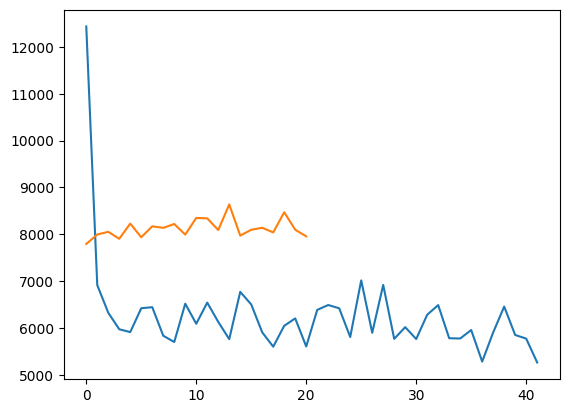

In [11]:
from matplotlib import pyplot as plt
losses = np.array(losses)
val_losses = np.array(val_losses)
fig, ax = plt.subplots()
ax.plot(losses)
ax.plot(val_losses)
plt.show()

In [12]:
#接下来为测试过程，
test_model = Transformer(src_size=1,trg_size=1,seq_len=seq_len,predict_len=predict_len,
                 embed_size = 256,num_layers=6,forward_expansion=4,heads=8,
                 dropout=0,device=device,max_len=5000).to(device)
test_model.load_state_dict(torch.load('best_model_atten.pth'))

<All keys matched successfully>

In [13]:
def test(model,device,test_loader):
    histories = []
    predicts = []
    ground_truth=[]
    model.eval()
    mse = nn.MSELoss()
    
    
    with torch.no_grad():
        for i,(seq,predict) in enumerate(valid_loader):
        
            seq = seq.unsqueeze(dim=2).float().to(device)
            predict = predict.float().to(device)
            output = model(seq)
            loss = criterion(output, predict)
            print('Test Loss:{:.4f}'.format(loss.item()))
            
            histories.append(seq)
            predicts.append(output)
            ground_truth.append(predict)
            
        return histories,predicts,ground_truth

In [14]:
histories,predicts,ground_truth = test(test_model,device,test_loader)

Test Loss:7990.3765
Test Loss:7783.1226
Test Loss:8131.1968
Test Loss:7113.5864


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]


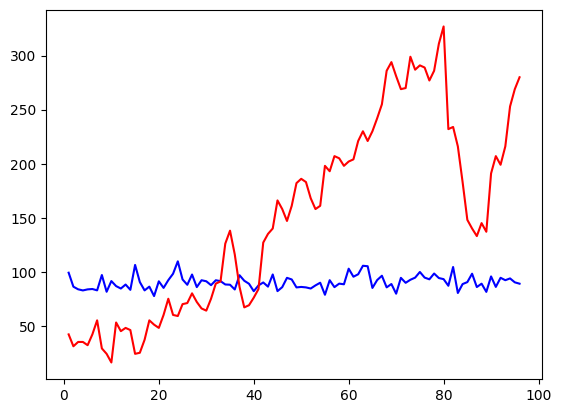

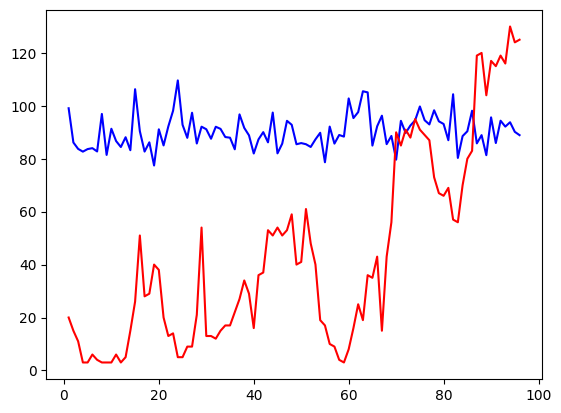

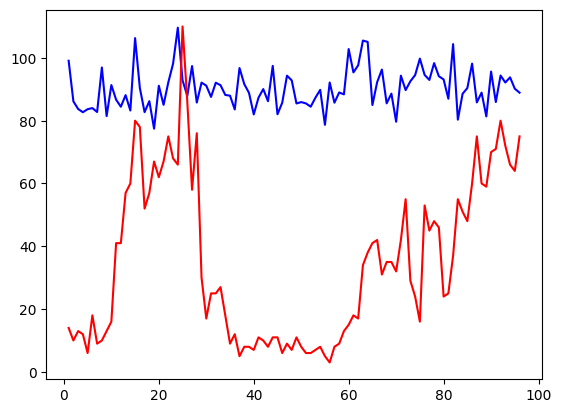

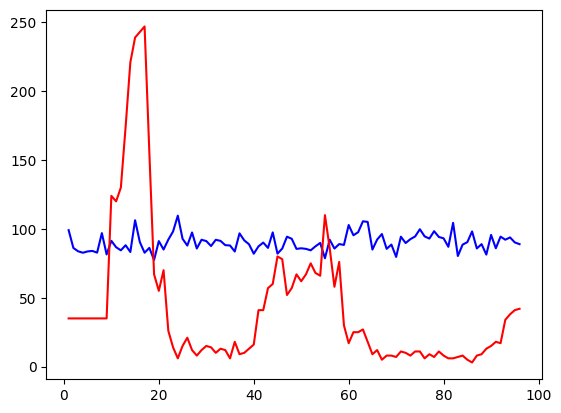

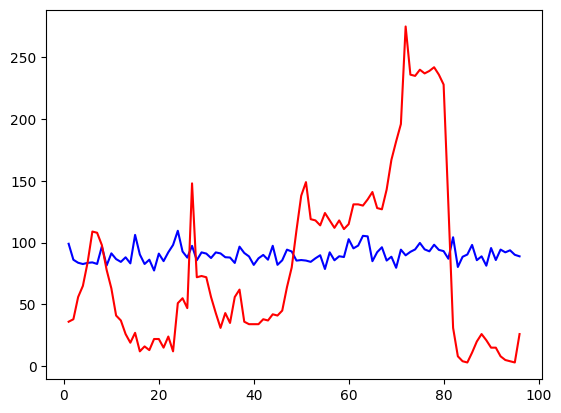

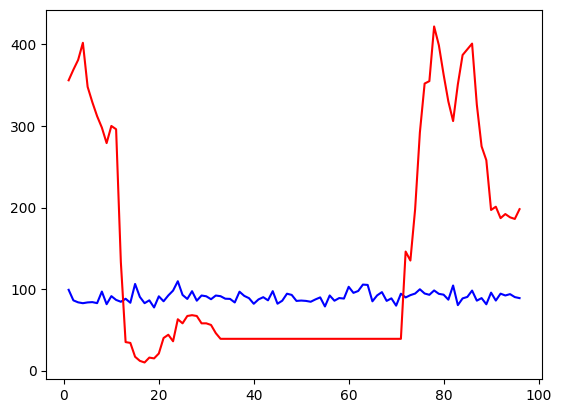

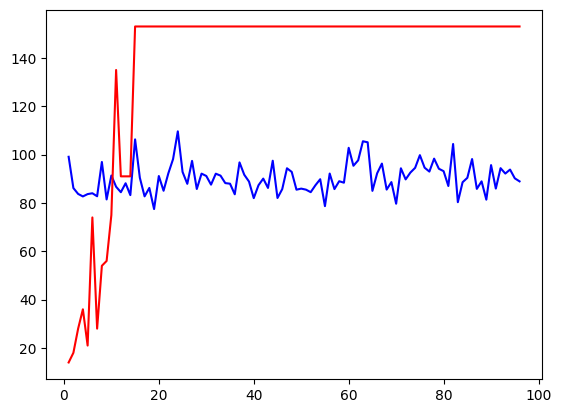

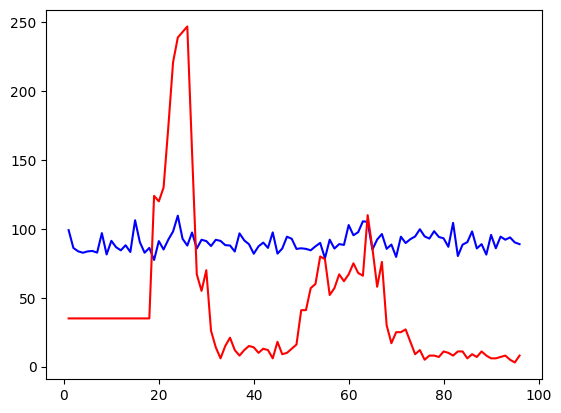

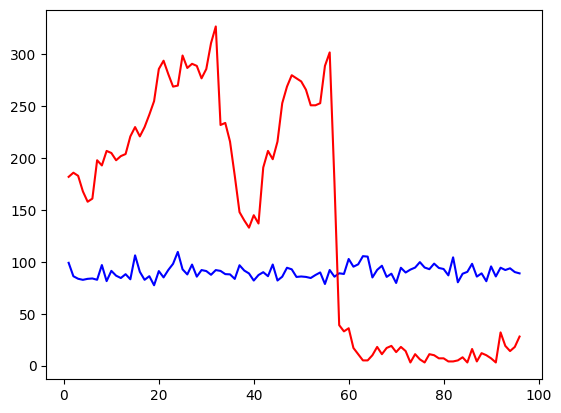

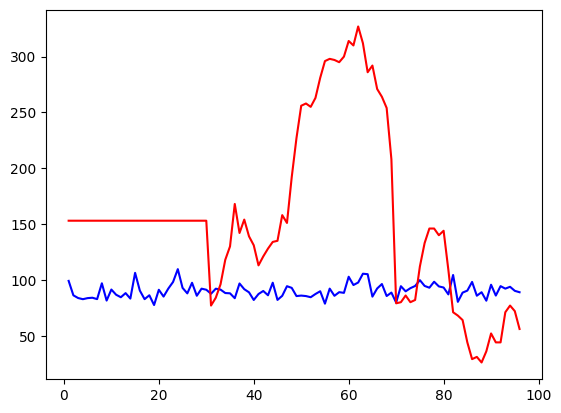

In [20]:
x1 = np.arange(histories[0].shape[2],histories[0].shape[2]+predicts[0].shape[1])
x2 = np.arange(histories[0].shape[2])
print(x1)
for i in range(10):
    y1 = predicts[0][i*10].cpu()
    y2 = ground_truth[0][i*10].cpu()
    y3 = histories[0][i,0,:].cpu()

    fig, ax = plt.subplots()
    ax.plot(x1, y1, label='predicts', color='blue')
    ax.plot(x1, y2, label='ground_truth', color='red')
    #ax.plot(x2,y3,label = 'histories',color='green')

    plt.show()